In [115]:
import mplfinance as mpf
import matplotlib.dates as mpl_dates
import math
from IPython.display import clear_output
import warnings
import time
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline
#%matplotlib notebook
pd.options.mode.chained_assignment = None
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
import cProfile
import pstats
import io
from pstats import SortKey

In [116]:
nifty5 = pd.read_csv('NEW_Cleaned_Nifty50_5min.csv')
nifty5['EMA']=nifty5['Close'].ewm(span=5, adjust=False).mean()

In [120]:
#c3 = pd.DataFrame(columns=['RRR','Number of trades','Maximum Drawdown','POP'])
c3 = pd.DataFrame(columns=['Minimum SL','Slippage','Number of trades','Maximum Drawdown','POP','Net Return'])
nn=20
c3['Minimum SL'] = np.repeat(np.linspace(0.5,30,nn),nn)
c3['Slippage'] = list(np.linspace(0.5,3,nn))*nn
#c3['RRR'] = np.linspace(1.5,3.5,21)
#c3['RRR'][0]=1
daysconsidered=min(234,1807) #offset to start for some given date
lastdateconsidered=0 #0 for 21st October 2022
years=[0, 234, 468, 702, 936, 1170, 1404]
#years=[234, 468, 702, 936, 1170, 1404]
for ii in [164]:#range(len(c3['Minimum SL'])): #[nn*nn-1]: 
    start = time.time()
    b=nifty5.Date.nunique()-lastdateconsidered
    a=b-daysconsidered

    c1 = pd.DataFrame(columns=['Date', 'Number of trades','Average time','Balance'])
    c1['Date'] = nifty5['Date']
    c1['Number of trades']=0
    c1['Average time']=0
    c1['Balance']=0

    c2 = pd.DataFrame(columns=['Date', 'Time','Balance','BoughtAt','SoldAt'])
    c2['Date'] = nifty5['Date']
    c2['Time'] = nifty5['Time']
    c2['Balance'][a*75] = round(25*nifty5['Open'][a*75],-4)
    c2['BoughtAt'] = 0
    c2['SoldAt'] = 0
        
    profp=[]
    lossp=[]
    losss=[]
    proff=[]
    profasl=[]
    slipp=[]
    gapp=[]
    th=[]

    def buy(i,j,tgt,sl):
        global profp,lossp,th
        byp=nifty5['Close'][i*75+j]
#             d=nifty5['Date'][i*75+j]
        k=j
        for k in range(j,70):
            if nifty5['Close'][i*75+k]<sl:            
                lossp.append(100*(byp-sl)/byp)
                th.append(k-j)
                return k, sl
            if nifty5['High'][i*75+k]>tgt:            
                profp.append(100*(tgt-byp)/byp)
                th.append(k-j)
                return k, tgt

        th.append(k-j)
        return k, nifty5['Close'][i*75+k]

    def sell(i,j,tgt,sl,slp):
        j+=1
        global profp,lossp,th
#             d=nifty5['Date'][i*75+j]
        k=j
        for k in range(j,74):
            if nifty5['High'][i*75+k]>sl:
#                 lossp.append(100*(sl-slp)/slp)
#                 losss.append(sl-slp)
#                 th.append(k-j)
                return k, sl
            if nifty5['Low'][i*75+k]<tgt:            
#                 profp.append(100*(slp-tgt)/slp)
#                 proff.append(slp-tgt)
#                 th.append(k-j)
                return k, tgt

#         th.append(k-j)
        return k, nifty5['Close'][i*75+k]

    proftolossratio=4 #c3.loc[ii,'RRR']
    slippage=1 #c3.loc[ii,'Slippage'] #in percentage terms
    gap=0.05 # Gap above nifty in percentage terms

    ini=c2['Balance'][a*75]#nifty5['Open'][a*75]
    balance=ini
#         minbalance=ini
#         maxbalance=0
    tgt=0.0
    sl=0.0
    profit=0.0
    leverage=5
    sellflag=1
    buyflag=0
    slip=slippage/100
    gap=gap/100
    tt=[]
    tt2=[]
    tt3=[]
    for i in range(a,b):
        n=max(1,math.floor(balance/nifty5['Open'][i*75]))
        profit=0
        k=0
        if i>a:
            c2.at[i*75, 'Balance'] = c2.loc[i*75-1, 'Balance']
        start1=time.time()
        for j in range(1,nifty5.Time.nunique()):
            start2=time.time()
            if j<k+1:
                tt2.append(time.time()-start2)
                continue  

            if j!=k:
                c2.at[i*75+j, 'Balance'] = c2.loc[i*75+j-1, 'Balance']

            if sellflag==1 and nifty5['Open'][i*75+j-1]>nifty5['EMA'][i*75+j-1] and nifty5['Close'][i*75+j-1]>nifty5['EMA'][i*75+j-1]:
                if (min(nifty5['Open'][i*75+j-1],nifty5['Close'][i*75+j-1])-nifty5['EMA'][i*75+j-1])<gap*nifty5['Close'][i*75+j-1]:
                    if nifty5['Low'][i*75+j]<nifty5['Low'][i*75+j-1] and (nifty5['High'][i*75+j-1]-nifty5['Low'][i*75+j-1])>15:#c3.loc[ii,'Minimum SL']:
                        start3=time.time()
                        slp=nifty5['Low'][i*75+j-1]
                        sl=nifty5['High'][i*75+j-1]
                        tgt=slp-(sl-slp)*proftolossratio
                        k, byp=sell(i,j,tgt,sl,slp)       
                        for j1 in range(j,k+1):
                            c2.at[i*75+j1, 'Balance'] = c2.loc[i*75+j1-1, 'Balance']
                        c1.at[i*75,'Number of trades'] += 1
                        c2.at[i*75+k,'Balance'] = c2.loc[i*75+k,'Balance']+n*(slp-byp)*leverage-nifty5['Close'][i*75+j]*slip
#                         profasl.append(n*(slp-nifty5['Close'][i*75+j])*leverage-nifty5['Close'][i*75+j]*slip)
#                         slipp.append(nifty5['Close'][i*75+j]*slip)
                        c2.at[i*75+k,'BoughtAt'] = byp
                        c2.at[i*75+j,'SoldAt'] = slp
#                         gapp.append(min(nifty5['Open'][i*75+j-1],nifty5['Close'][i*75+j-1])-nifty5['EMA'][i*75+j-1])
                        tt2.append(time.time()-start2)
                        tt3.append(time.time()-start3)
                        continue
            tt2.append(time.time()-start2)
        tt.append(time.time()-start1)   
#                 if buyflag==1 and nifty5['Close'][i*75+j-1]<nifty5['EMA'][i*75+j-1] and nifty5['Open'][i*75+j-1]<nifty5['EMA'][i*75+j-1]:
#                     if (nifty5['EMA'][i*75+j-1]-max(nifty5['Open'][i*75+j-1],nifty5['Close'][i*75+j-1]))<gap*nifty5['Close'][i*75+j-1]:
#                         if nifty5['Close'][i*75+j]>nifty5['EMA'][i*75+j]:
#                             stpls=0-nifty5['Low'][i*75+j-1]+nifty5['Close'][i*75+j]
#                             trgt=nifty5['Close'][i*75+j]+stpls*proftolossratio
#                             k, slp=buy(i,j,trgt,nifty5['High'][i*75+j-1])       
#                             for j1 in range(j,k+1):
#                                 c2.at[i*75+j1, 'Balance'] = c2.loc[i*75+j1-1, 'Balance']
#                             c1.at[i*75, 'Number of trades']+=1
#                             c2.at[i*75+k, 'Balance'] = c2.loc[i*75+k, 'Balance']+n*(slp-nifty5['Close'][i*75+j])*leverage-nifty5['Close'][i*75+j]*slip

#                             c2.at[i*75+j,'BoughtAt'] = nifty5['Close'][i*75+j]
#                             c2.at[i*75+k,'SoldAt'] = slp
#                             continue

#                 if sellflag==1 and nifty5['Open'][i*75+j-1]>nifty5['EMA'][i*75+j-1] and nifty5['Close'][i*75+j-1]>nifty5['Open'][i*75+j-1]:
#                     if 1==1:
#                         if nifty5['Low'][i*75+j]<nifty5['Open'][i*75+j-1]:
#                             slp=nifty5['Open'][i*75+j-1]
#                             sl=nifty5['High'][i*75+j-1]
#                             tgt=slp-(sl-slp)*proftolossratio
#                             k, byp=sell(i,j,tgt,sl)       
#                             for j1 in range(j,k+1):
#                                 c2.at[i*75+j1, 'Balance'] = c2.loc[i*75+j1-1, 'Balance']
#                             c1.at[i*75,'Number of trades']+=1
#                             c2.at[i*75+k,'Balance'] = c2.loc[i*75+k,'Balance']+n*(slp-byp)*leverage-nifty5['Close'][i*75+j]*slip
#                             c2.at[i*75+k,'BoughtAt'] = byp
#                             c2.at[i*75+j,'SoldAt'] = slp
#                             continue

#         th=np.array(th)
#         c1.at[i*75, 'Average time'] = th.mean()*5
#         th=[] 
        balance= c2.at[i*75+j, 'Balance']
        c1.at[i*75, 'Balance'] = balance
        if balance<0:
            print("Total Loss")
            break
#         if balance>=maxbalance:
#             maxbalance=balance
#         if balance<minbalance:
#             minbalance=balance
        
#     ttt=time.time()-start
#     tt=np.array(tt)
#     tt2=np.array(tt2)
#     tt3=np.array(tt3)
#     print('\nTime Taken per day: {:.4f} ms'.format(tt.mean()*1000))
#     print('\nTime Taken per 5min tick: {:.4f} ms'.format(tt2.mean()*1000))
#     print('\nTime Taken per trade: {:.4f} ms'.format(tt3.mean()*1000))
#     print('\nTime Taken for main code: {:.4f} s'.format(ttt))

    res=(balance-ini)/ini
    Roll_Max = c2['Balance'][a*75:b*75:75].cummax()
    Daily_Drawdown = c2['Balance'][a*75:b*75:75]/Roll_Max - 1.0
    Max_Daily_Drawdown = Daily_Drawdown.cummin()
#         print('\nTotal count of trade days :',len(c1[c1['Number of trades']!=0]),'out of ',b-a,' days')
#         print('Average number of trades per day: {:.2f}'.format(c1[c1['Number of trades']!=0]['Number of trades'].mean()))
#         print('Average time held per trade: {:.2f} minutes \n'.format(c1[c1['Number of trades']!=0]['Average time'].mean()))
#         try:
#             irr=100*(pow(10,math.log(1+res,10)/(daysconsidered/234))-1)
#             print("Final Balance is ₹{:.2f} with return of {:.2f}% Annualized to {:.2f}%".format(balance,res*100,irr))
#         except:
#             print("Final Balance is ₹{:.2f} with a loss of {:.2f} at -{:.2f}%".format(balance,ini-balance,100*(ini-balance)/ini))
#         print("Minimum Balance was ₹{:.2f} and Maximum Balance was ₹{:.2f}".format(minbalance,maxbalance))
#         ren=(nifty5['Close'][i*75+j]-nifty5['Close'][a*75+j])/nifty5['Close'][a*75+j]
#         irrn=100*(pow(10,math.log(1+ren,10)/(daysconsidered/234))-1)
#         print("Nifty Return for the same time period is {:.2f}% Annualized to {:.2f}%".format(100*ren,irrn))
    profp=np.array(profp)
    lossp=np.array(lossp)
    pn=len(profp)
    ln=len(lossp)
    pm=profp.mean()
    lm=lossp.mean()
#         print('Iteration for RRR:',c3.loc[ii,'RRR'],'Done')
#         print('\nNumber of Profits: {} Losses: {} \nAverage Profit: {:.2f}% Average Loss: {:.2f}%'.format(pn,ln,pm,lm))
#         print('Win ratio of: {:.2f}% and net profit per trade of {:.2f}%'.format(100*pn/(ln+pn),(pm*pn-lm*ln)/(pn+ln)))
#         print('Slippage: {:.2f}% \nRisk to Reward Ratio of: {}'.format(slip*100,proftolossratio))
#         print('Intial Balance was Rs.{:.2f}'.format(c2['Balance'][a*75]))

#         c3 = pd.DataFrame(columns=['Minimum SL','Number of trades','Maximum Drawdown','POP','Net Return'])
#     c3.at[ii,'Number of trades']=c1[c1['Number of trades']!=0]['Number of trades'].mean()
#     c3.at[ii,'Maximum Drawdown']=100*min(np.array(Max_Daily_Drawdown))
#     c3.at[ii,'POP']=100*pn/(ln+pn)
#     c3.at[ii,'Net Return']=res*100
    
#    print("The time of execution of above program is: {:.2f} s. Hence total runtime for entire code will be: {:.2f} hrs".format(ti,ti*nn*nn/3600))
#     f=75
#     plotnifty=nifty5.iloc[a*75:b*75:f, :]
#     plotnifty.index= pd.to_datetime(plotnifty.Date)
#     plotnifty.drop('Date',axis=1,inplace=True)
#     buytr = np.array(c2['BoughtAt'])
#     selltr = np.array(c2['SoldAt'])
#     buytr[ buytr==0 ] = np.nan
#     selltr[ selltr==0 ] = np.nan
#     c2['BoughtAt'] = buytr 
#     c2['SoldAt'] = selltr
#     #Creating Subplots
#     plt.figure(dpi=1200)
#     fig, ax = plt.subplots(figsize=(20,7.5))
#     #plt.yscale("log")
#     mc = mpf.make_marketcolors(up='g',down='r')
#     s  = mpf.make_mpf_style(marketcolors=mc)
#     mpf.plot(plotnifty[:], type='candle',style=s,ax=ax,warn_too_much_data=2000)
#     plt.plot(plotnifty['EMA'].values,'k',label='EMA Normal')
#     plt.plot(c2['Balance'][a*75::f].values/25,'b',label='Balance')
#     #plt.plot(c2['BoughtAt'][a*75::f].values,'g^')
#     #plt.plot(c2['SoldAt'][a*75::f].values,'rv')
#     # Setting labels & titles
#     ax.set_xlabel('Date')
#     ax.set_ylabel('Price')
#     #fig.suptitle('Daily Candlestick Chart of nifty')
#     fig.suptitle('Strategy comparison from '+nifty5.iloc[a*75:b*75:f, :]['Date'].iat[0]+' to '+nifty5.iloc[a*75:b*75:f, :]['Date'].iat[-1])
#     fig.tight_layout()
#     plt.grid()
#     plt.legend()
#     plt.savefig(nifty5.iloc[a*75:b*75:f, :]['Date'].iat[0]+' to '+nifty5.iloc[a*75:b*75:f, :]['Date'].iat[-1])

UsageError: Line magic function `%%timeit` not found.


In [113]:
1000*(tt.mean()-tt2.sum()/len(tt))

4.447097452277812

Total Time: 2.0669s, Time per day: 8.5836ms, Timer per 5min tick: 0.0559ms, Time per trade: 0.4837ms



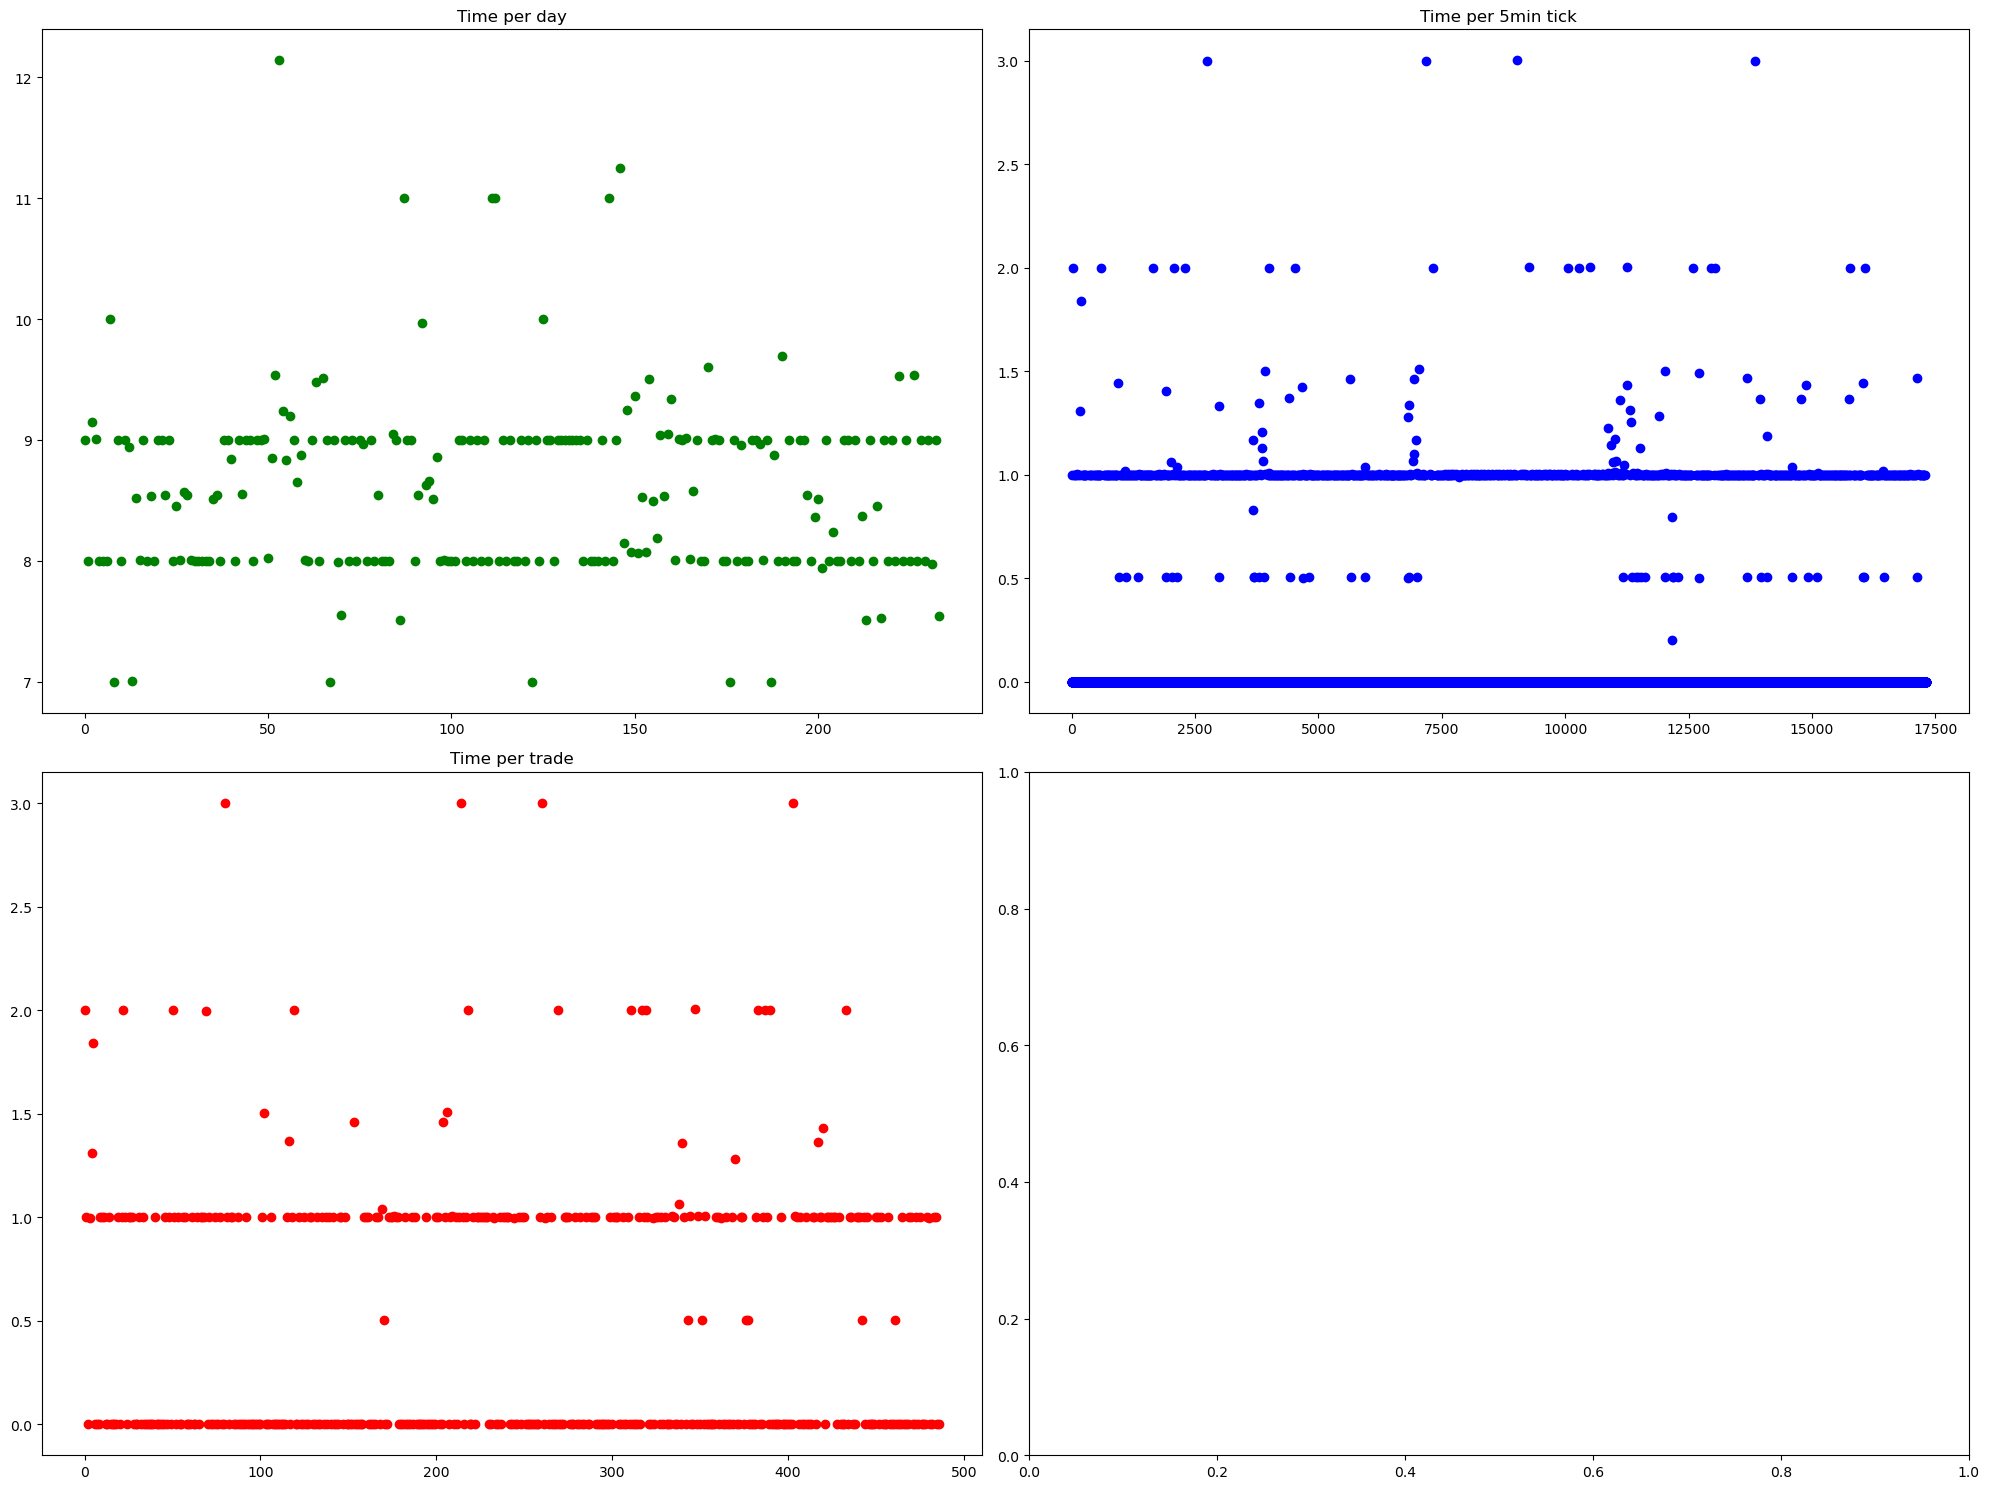

In [114]:
print('Total Time: {:.4f}s, Time per day: {:.4f}ms, Timer per 5min tick: {:.4f}ms, Time per trade: {:.4f}ms\n'.format(ttt,1000*tt.mean(),1000*tt2.mean(),1000*tt3.mean()))
fig, ax = plt.subplots(2,2,figsize=(20,15))
ax[0,0].plot(tt*1000,'go')
ax[0,0].set_title('Time per day')

ax[0,1].plot(tt2*1000,'bo')
ax[0,1].set_title('Time per 5min tick')

ax[1,0].plot(tt3*1000,'ro')
ax[1,0].set_title('Time per trade')

# Setting labels & titles
fig.tight_layout()

In [547]:
nt=np.zeros([nn,nn])
for i in range(nn):
    for j in range(nn):
        nt[i][j]=c3.loc[i*20+j,'Number of trades']
md=np.zeros([nn,nn])
for i in range(nn):
    for j in range(nn):
        md[i][j]=c3.loc[i*20+j,'Maximum Drawdown']
pop=np.zeros([nn,nn])
for i in range(nn):
    for j in range(nn):
        pop[i][j]=c3.loc[i*20+j,'POP']
nr=np.zeros([nn,nn])
for i in range(nn):
    for j in range(nn):
        nr[i][j]=c3.loc[i*20+j,'Net Return']

<IPython.core.display.Javascript object>


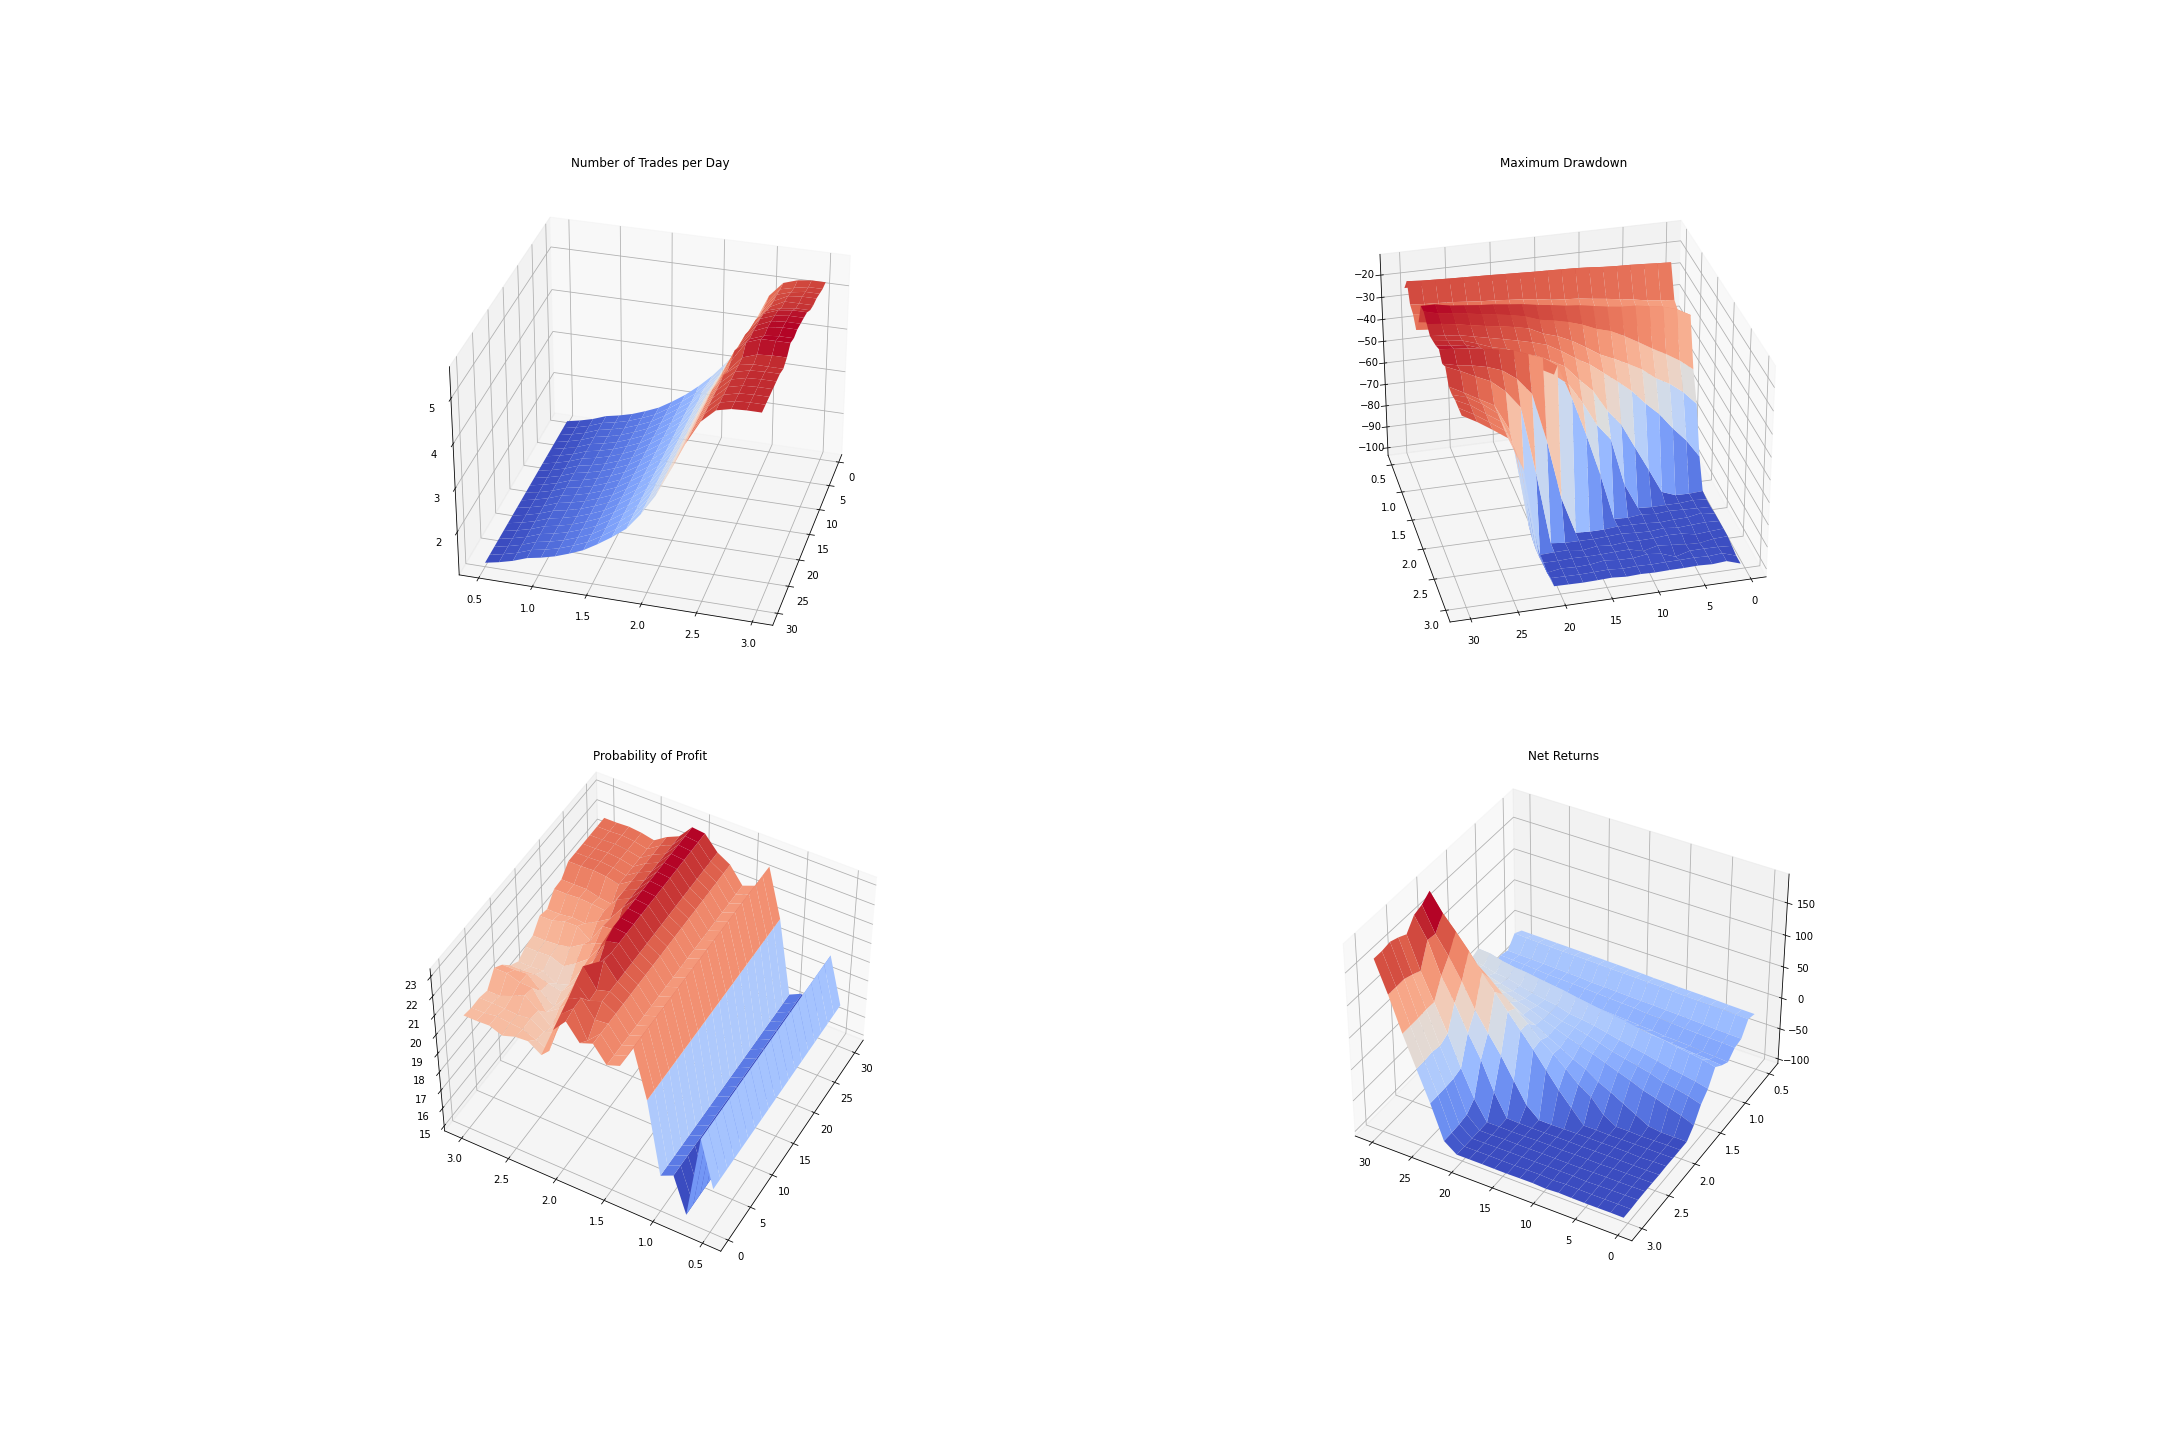

In [567]:
fig = plt.figure(figsize=(30,20))
X = np.linspace(30,0.5,nn)
Y = np.linspace(3,0.5,nn)
X, Y = np.meshgrid(X, Y)
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)
ax1 = fig.add_subplot(spec[0, 0], projection='3d')
ax1.set_title("Number of Trades per Day")
surf = ax1.plot_surface(X, Y, nt, cmap=cm.coolwarm,linewidth=0, antialiased=True)

ax2 = fig.add_subplot(spec[0, 1], projection='3d')
ax2.set_title("Maximum Drawdown")
surf = ax2.plot_surface(X, Y, md, cmap=cm.coolwarm,linewidth=0, antialiased=True)

ax3 = fig.add_subplot(spec[1, 0], projection='3d')
ax3.set_title("Probability of Profit")
surf = ax3.plot_surface(X, Y, pop, cmap=cm.coolwarm,linewidth=0, antialiased=True)

ax4 = fig.add_subplot(spec[1, 1], projection='3d')
ax4.set_title("Net Returns")
surf = ax4.plot_surface(X, Y, nr, cmap=cm.coolwarm,linewidth=0, antialiased=True)
# Customize the z axis.
# ax.set_zlim(-1.01, 1.01)
# ax.zaxis.set_major_locator(LinearLocator(10))
# # A StrMethodFormatter is used automatically
# ax.zaxis.set_major_formatter('{x:.02f}')

# # Add a color bar which maps values to colors.
# fig.colorbar(surf, shrink=0.5, aspect=5)

<Figure size 7680x5760 with 0 Axes>

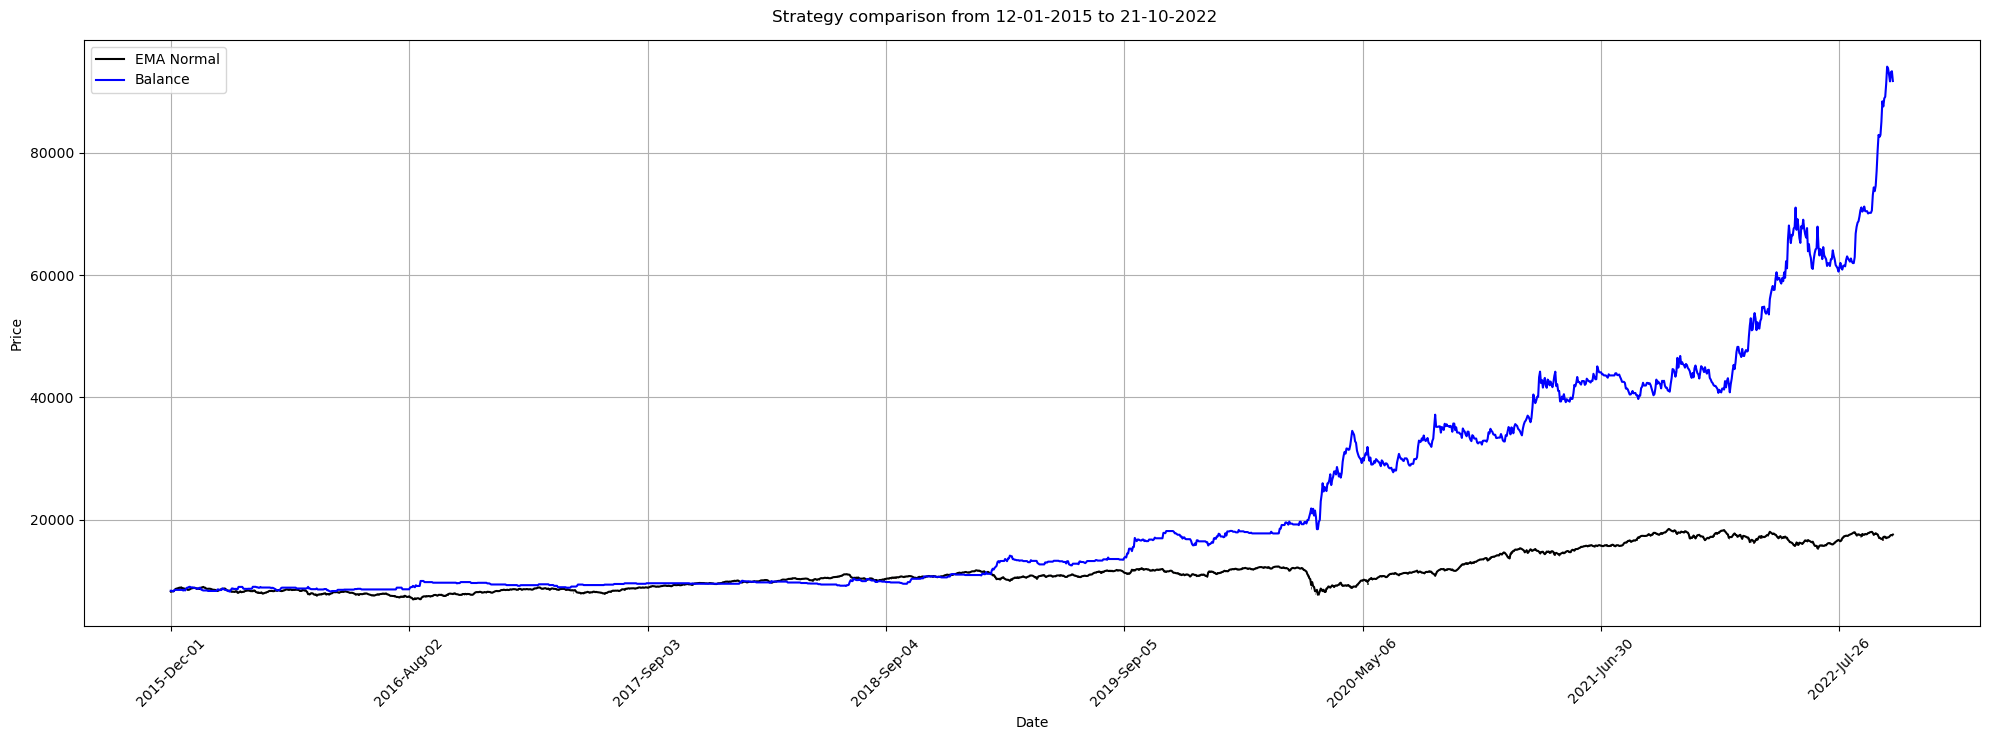

In [51]:
f=75
plotnifty=nifty5.iloc[a*75:b*75:f, :]
plotnifty.index= pd.to_datetime(plotnifty.Date)
plotnifty.drop('Date',axis=1,inplace=True)
buytr = np.array(c2['BoughtAt'])
selltr = np.array(c2['SoldAt'])
buytr[ buytr==0 ] = np.nan
selltr[ selltr==0 ] = np.nan
c2['BoughtAt'] = buytr 
c2['SoldAt'] = selltr
#Creating Subplots
plt.figure(dpi=1200)
fig, ax = plt.subplots(figsize=(20,7.5))
#plt.yscale("log")
mc = mpf.make_marketcolors(up='g',down='r')
s  = mpf.make_mpf_style(marketcolors=mc)
mpf.plot(plotnifty[:], type='candle',style=s,ax=ax,warn_too_much_data=2000)
plt.plot(plotnifty['EMA'].values,'k',label='EMA Normal')
plt.plot(c2['Balance'][a*75::f].values/25,'b',label='Balance')
#plt.plot(c2['BoughtAt'][a*75::f].values,'g^')
#plt.plot(c2['SoldAt'][a*75::f].values,'rv')
# Setting labels & titles
ax.set_xlabel('Date')
ax.set_ylabel('Price')
#fig.suptitle('Daily Candlestick Chart of nifty')
fig.suptitle('Strategy comparison from '+nifty5.iloc[a*75:b*75:f, :]['Date'].iat[0]+' to '+nifty5.iloc[a*75:b*75:f, :]['Date'].iat[-1])
fig.tight_layout()
plt.grid()
plt.legend()
plt.savefig(nifty5.iloc[a*75:b*75:f, :]['Date'].iat[0]+' to '+nifty5.iloc[a*75:b*75:f, :]['Date'].iat[-1])

In [470]:
# fig, ax = plt.subplots(2,2,figsize=(20,15))
# ax[0,0].plot(c3['Minimum SL'],c3['Number of trades'],'r')
# ax[0,0].set_title("Number of trades")

# ax[0,1].plot(c3['Minimum SL'],c3['Maximum Drawdown'],'g')
# ax[0,1].set_title("Maximum Drawdown")

# ax[1,0].plot(c3['Minimum SL'],c3['POP'],'k')
# ax[1,0].set_title("Probability of Profit")

# ax[1,1].plot(c3['Minimum SL'],c3['Net Return'],'b')
# ax[1,1].set_title("Net Return")

# fig.tight_layout()
# plt.savefig('Optimum Stoploss selection')

Average Loss: 18.88, Average Profit: 71.54, Average Profit after slippage: 215.68
Average Slippage: 142.64, Average gap: 3.12, Average time taken: 0.008452s 



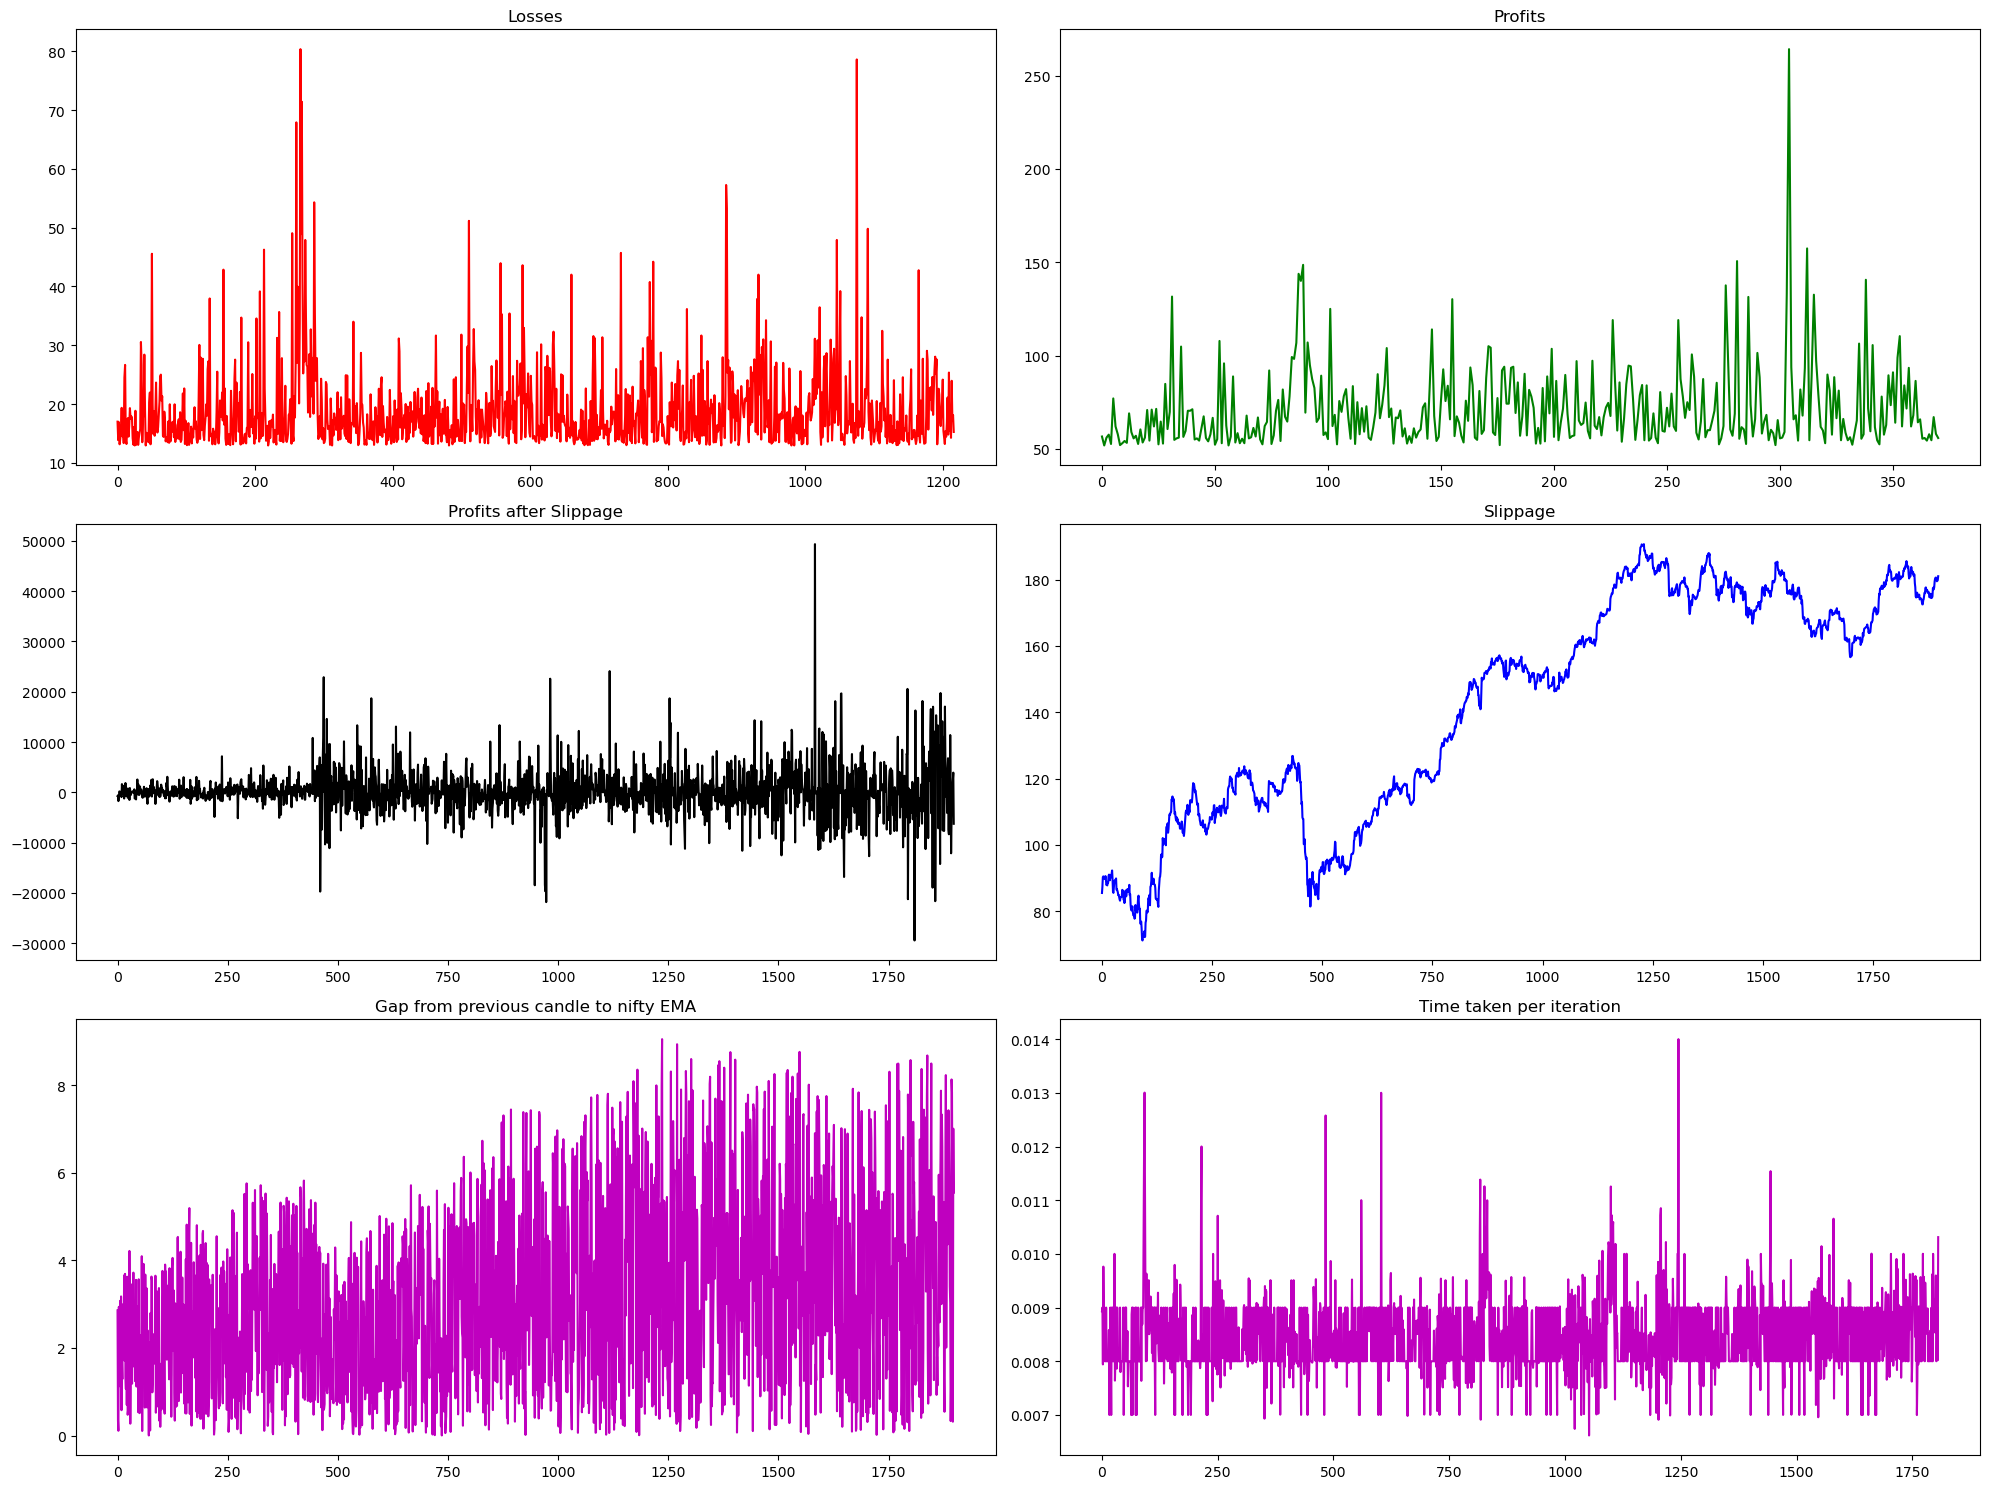

In [48]:
losss=np.array(losss)
proff=np.array(proff)
profasl=np.array(profasl)
slipp=np.array(slipp)
gapp=np.array(gapp)
print('Average Loss: {:.2f}, Average Profit: {:.2f}, Average Profit after slippage: {:.2f}\nAverage Slippage: {:.2f}, Average gap: {:.2f}, Average time taken: {:.6f}s \n'.format(losss.mean(),proff.mean(),profasl.mean(),slipp.mean(),gapp.mean(),tt.mean()))
fig, ax = plt.subplots(3,2,figsize=(20,15))
ax[0,0].plot(losss,'r')
ax[0,0].set_title("Losses")

ax[0,1].plot(proff,'g')
ax[0,1].set_title("Profits")

ax[1,0].plot(profasl,'k')
ax[1,0].set_title("Profits after Slippage")

ax[1,1].plot(slipp,'b')
ax[1,1].set_title("Slippage")

ax[2,0].plot(gapp,'m')
ax[2,0].set_title("Gap from previous candle to nifty EMA")

ax[2,1].plot(tt,'m')
ax[2,1].set_title("Time taken per iteration")
# Setting labels & titles
fig.tight_layout()

In [34]:
c4 = pd.DataFrame(columns=['Date', 'Time','Nifty','Strat','NiftyR','StratR'])
c4['Date'] = nifty5.iloc[a*75::f, :]['Date']
c4['Time'] = nifty5.iloc[a*75::f, :]['Time']
c4['Nifty'] = nifty5.iloc[a*75::f, :]['Close']
c4['Strat'] = c2['Balance'][a*75::f].values
c4.reset_index(inplace=True)
c4.drop('index',axis=1,inplace=True)
c4.at[0,'NiftyR'] = 0
c4.at[0,'StratR'] = 0
for i in range(1,len(nifty5.iloc[a*75::f, :]['Close'])):
    c4.at[i,'NiftyR'] = 100*(c4.loc[i,'Nifty']-c4.loc[i-1,'Nifty'])/c4.loc[i,'Nifty']
    c4.at[i,'StratR'] = 100*(c4.loc[i,'Strat']-c4.loc[i-1,'Strat'])/c4.loc[i,'Strat']
print('Standard Deviation for Nifty: {:.3f} and for Strategy: {:.3f}'.format(c4['Nifty'].std(),c4['Strat'].std()))
print('Standard Deviation of Daily Returns for Nifty: {:.3f}% and for Strategy: {:.3f}%'.format(c4['NiftyR'].std(),c4['StratR'].std()))
#print('Average Daily Returns for Nifty: {:.3f}% and for Strategy: {:.3f}%'.format(c4['NiftyR'].mean(),c4['StratR'].mean()))

Standard Deviation for Nifty: 1582.995 and for Strategy: 49405.957
Standard Deviation of Daily Returns for Nifty: 1.148% and for Strategy: 1.818%


In [35]:
Roll_Max = c2['Balance'][a*75:b*75:75].cummax()
Daily_Drawdown = c2['Balance'][a*75:b*75:75]/Roll_Max - 1.0
Max_Daily_Drawdown = Daily_Drawdown.cummin()
print(100*min(np.array(Max_Daily_Drawdown)))

-21.32342146312545
